In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [1]:


from fastai.imports import *
from fastai.structured import *

from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_string_dtype, is_object_dtype
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display
import feather

import seaborn as sns
import matplotlib.pyplot as plt
from pdpbox import pdp
from plotnine import *

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from treeinterpreter import treeinterpreter as ti
import xgboost as xgb


/home/heatmap/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# 1. Load data

In [2]:
np.random.seed(42)

In [222]:
PATH = 'data/bulldozer/'

In [223]:
!ls {PATH}

'Data Dictionary.xlsx'		    Test.csv	        Train.zip
 Machine_Appendix.csv		    Train.7z	        Valid.7z
 median_benchmark.csv		    TrainAndValid.7z    Valid.csv
 processed			    TrainAndValid.csv   ValidSolution.csv
 random_forest_benchmark_test.csv   TrainAndValid.zip   Valid.zip
 raw				    Train.csv


In [224]:
df_raw = pd.read_csv(f'{PATH}TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

In [225]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

####  Safe data in the fast readable feather format 

In [15]:
os.makedirs('data/bulldozer', exist_ok=True)
df_raw.to_feather('data/bulldozer/raw')

In [16]:
!ls {PATH}

'Data Dictionary.xlsx'		    Train.7z	        Valid.7z
 Machine_Appendix.csv		    TrainAndValid.7z    Valid.csv
 median_benchmark.csv		    TrainAndValid.csv   ValidSolution.csv
 random_forest_benchmark_test.csv   TrainAndValid.zip   Valid.zip
 raw				    Train.csv
 Test.csv			    Train.zip


In [3]:
df_raw = feather.read_dataframe('data/bulldozer/raw')

# 2. Preprocessing

In [264]:
# create a copy of the raw data
df_tmp = df_raw.copy()

In [265]:
df_tmp.shape

(412698, 53)

In [266]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,None,None,None,None,None,None,None,None,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,None,None,None,None,None,None,None,None,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,None,None,None,None,None,None,None,None,None,None
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,None,None,None,None,None,None,None,None,None,None
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,None,None,None,None,None,None,None,None,None,None


In [74]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [268]:
display_all(df_tmp.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


## 2.1 Dates

In [269]:
df_tmp.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

In [270]:
def prep_date(df, date_col):
    df["saleYear"] = df[date_col].dt.year
    df["saleMonth"] = df[date_col].dt.month
    df["saleDay"] = df[date_col].dt.day
    df["saleDayofweek"] = df[date_col].dt.dayofweek
    df["saleWeekofyear"] = df[date_col].dt.weekofyear
    df["saleDayofyear"] = df[date_col].dt.dayofyear
    df["saleQuarter"] = df[date_col].dt.quarter
    df["saleIsWeekend"] = np.where((df[date_col].dt.day_name == ['Sunday', 'Saturday']),1,0)
    df["saleIsQuarterStart"] = np.where(df[date_col].dt.month.isin([1, 4, 7, 10]),1 ,0)
    df["saleIsQuarterEnd"] = np.where(df[date_col].dt.month.isin([3, 6, 9, 12]),1 ,0)
    df.drop(date_col, axis=1, inplace=True)
    
    return df

In [271]:
df_tmp= prep_date(df_tmp, 'saledate')

In [272]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleYear,saleMonth,saleDay,saleDayofweek,saleWeekofyear,saleDayofyear,saleQuarter,saleIsWeekend,saleIsQuarterStart,saleIsQuarterEnd
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,521D,...,2006,11,16,3,46,320,4,0,0,0
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,950FII,...,2004,3,26,4,13,86,1,0,0,1
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,226,...,2004,2,26,3,9,57,1,0,0,0
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,2011,5,19,3,20,139,2,0,0,0
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,2009,7,23,3,30,204,3,0,1,0


## 2.2 Missing Values in numeric fields

In [273]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [274]:
df_tmp.auctioneerID.describe()

count    392562.000000
mean          6.585268
std          17.158409
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          99.000000
Name: auctioneerID, dtype: float64

AuctioneerID clearly looks like a nominal variable with a specific ID for an Auctioneer . Imputing it with the median would make no sense in this case so we transform it into a string which will later be transformed into a categorical variable.

In [275]:
df_tmp['auctioneerID'] = df_tmp['auctioneerID'].astype(str)

In [276]:
df_tmp['MachineHoursCurrentMeter'].describe()

count    1.475040e+05
mean     3.522988e+03
std      2.716993e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.209000e+03
max      2.483300e+06
Name: MachineHoursCurrentMeter, dtype: float64

In [37]:
def fix_na_num (df, col):
    df[col+'_na'] = pd.isnull(df[col]) 
    df[col].fillna(df[col].median(), inplace=True)

In [278]:
fix_na_num(df_tmp, 'MachineHoursCurrentMeter')

In [279]:
df_tmp.MachineHoursCurrentMeter.isnull().value_counts()

False    412698
Name: MachineHoursCurrentMeter, dtype: int64

## 2.3 Missing Values in categorical fields

In [280]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
        print(content.unique())

auctioneerID
['3.0' '1.0' '2.0' '11.0' '4.0' '7.0' '99.0' '6.0' '5.0' '18.0' '17.0' '22.0' '20.0' '14.0' '16.0' '21.0'
 '9.0' '13.0' '12.0' '23.0' '10.0' '15.0' '19.0' '8.0' '28.0' '25.0' '27.0' '24.0' 'nan' '0.0' '26.0']
UsageBand
['Low' 'High' 'Medium' None]
fiModelDesc
['521D' '950FII' '226' ... '716AVHP' '530E' '55N2']
fiBaseModel
['521' '950' '226' ... '336' 'WLK15' 'R964']
fiSecondaryDesc
['D' 'F' None 'G' 'E' 'HAG' 'B' 'NX' 'SUPER K' 'STD' 'BL' 'Z' 'C' 'XT' 'A' 'H' 'MR' 'PT' 'L' 'M' 'J' 'SE'
 'SXT' 'HD' 'LC' 'SUPER M' 'LX' 'SUPER L' 'LE' 'K' 'S' 'R' 'P' 'SG' 'US' 'UU' 'WX' 'PX' 'N' 'ZTM' 'SUPER E'
 'XL' 'MXT' 'EX' '-2' 'LCM' 'GT' 'TM' 'HZ' 'AX' 'DXT' '3' 'SR' '7' 'ZTS' 'B     ' 'T' 'UR' '-3' 'V' 'ZT' '1'
 'SUPER M PLUS' 'BZD' 'DZ' 'WD' 'LGP' 'SRLC' 'CH' 'CS' 'M      ' 'ZHS G' 'Q' 'MRX' 'FR' 'UNA' 'R-2' 'PS' 'AG'
 'URG' 'NE' 'U' '2' 'SB' 'TX' 'TTL' 'JX' 'LT' 'MSR SPIN ACE' 'HF' 'HDSL' 'LCD' 'X' 'LS' 'EST' 'LR' 'TC'
 'BLGP' 'USR' 'RC' 'SJ' 'ZF' 'SUPER LE' 'MT' 'SUPER R' 'C      ' 

[None 'None or Unspecified' 'Yes']
Ripper
[None 'None or Unspecified' 'Yes' 'Single Shank' 'Multi Shank']
Scarifier
[None 'Yes' 'None or Unspecified']
Tip_Control
[None 'Sideshift & Tip' 'None or Unspecified' 'Tip']
Tire_Size
['None or Unspecified' '23.5' None '13"' '26.5' '29.5' '14"' '20.5' '17.5"' '15.5"' '20.5"' '17.5' '7.0"'
 '15.5' '23.5"' '10"' '23.1"' '10 inch']
Coupler
['None or Unspecified' None 'Manual' 'Hydraulic']
Coupler_System
[None 'None or Unspecified' 'Yes']
Grouser_Tracks
[None 'None or Unspecified' 'Yes']
Hydraulics_Flow
[None 'Standard' 'High Flow' 'None or Unspecified']
Track_Type
[None 'Steel' 'Rubber']
Undercarriage_Pad_Width
[None 'None or Unspecified' '16 inch' '32 inch' '28 inch' '30 inch' '22 inch' '24 inch' '18 inch' '36 inch'
 '20 inch' '27 inch' '15 inch' '26 inch' '34 inch' '33 inch' '14 inch' '31 inch' '25 inch' '31.5 inch']
Stick_Length
[None 'None or Unspecified' '11\' 0"' '15\' 9"' '10\' 2"' '10\' 6"' '9\' 10"' '10\' 10"' '9\' 6"' '9\' 7"'
 '12\' 8"'

In [36]:
def string_norm(df):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan) 
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('', np.nan)

In [282]:
string_norm(df_tmp)

Before we convert string columns to categories we can transform Tire_Size and Undercarriage_Pad_Width to numeric columns by removing "the inches".

In [35]:
def remove_inch(df, colname):
    df[colname] = df[colname].str.extract(r'([0-9.]*)', expand=True)
    df[colname] = pd.to_numeric(df[colname])

In [284]:
remove_inch(df_tmp, 'Tire_Size')
remove_inch(df_tmp, 'Undercarriage_Pad_Width')
fix_na_num(df_tmp, 'Tire_Size')
fix_na_num(df_tmp, 'Undercarriage_Pad_Width')

Now we can convert the string columns to categories.

In [34]:
def to_cat(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

def to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [286]:
to_cat(df_tmp)

In [41]:
#to_catcode(df_tmp)

In [287]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofweek,saleWeekofyear,saleDayofyear,saleQuarter,saleIsWeekend,saleIsQuarterStart,saleIsQuarterEnd,MachineHoursCurrentMeter_na,Tire_Size_na,Undercarriage_Pad_Width_na
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,low,521d,...,3,46,320,4,0,0,0,False,True,True
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,low,950fii,...,4,13,86,1,0,0,1,False,False,True
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,high,226,...,3,9,57,1,0,0,0,False,True,True
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,high,pc120-6e,...,3,20,139,2,0,0,0,False,True,True
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,medium,s175,...,3,30,204,3,0,1,0,False,True,True


In [288]:
df_tmp['SalePrice'] = np.log(df_tmp['SalePrice'])
#df_raw['SalePrice'] = np.log(df_raw['SalePrice'])

Save processed dataframe to feather

In [44]:
df_tmp.to_feather('data/bulldozer/processed')

In [233]:
def preprocess_df(df):
    
    def prep_date(df, date_col):
        df["saleYear"] = df[date_col].dt.year
        df["saleMonth"] = df[date_col].dt.month
        df["saleDay"] = df[date_col].dt.day
        df["saleDayofweek"] = df[date_col].dt.dayofweek
        df["saleWeekofyear"] = df[date_col].dt.weekofyear
        df["saleDayofyear"] = df[date_col].dt.dayofyear
        df["saleQuarter"] = df[date_col].dt.quarter
        df["saleIsWeekend"] = np.where((df[date_col].dt.day_name == ['Sunday', 'Saturday']),1,0)
        df["saleIsQuarterStart"] = np.where(df[date_col].dt.month.isin([1, 4, 7, 10]),1 ,0)
        df["saleIsQuarterEnd"] = np.where(df[date_col].dt.month.isin([3, 6, 9, 12]),1 ,0)
        df.drop(date_col, axis=1, inplace=True)
    
        return df

    
    df= prep_date(df, 'saledate')
    
    df['auctioneerID'] = df['auctioneerID'].astype(str)
    
    def fix_na_num (df, col):
        df[col+'_na'] = pd.isnull(df[col]) 
        df[col].fillna(df[col].median(), inplace=True)
    
    fix_na_num(df, 'MachineHoursCurrentMeter')
    
    def string_norm(df):
        for col in df.columns:
            if is_string_dtype(df[col]) or is_object_dtype(df[col]):
                df[col] = df[col].str.lower()
                df[col] = df[col].fillna(np.nan) 
                df[col] = df[col].replace('none or unspecified', np.nan)
                df[col] = df[col].replace('none', np.nan)
                df[col] = df[col].replace('', np.nan)
            
    string_norm(df)
    
    def remove_inch(df, colname):
        df[colname] = df[colname].str.extract(r'([0-9.]*)', expand=True)
        df[colname] = pd.to_numeric(df[colname])

    remove_inch(df, 'Tire_Size')
    remove_inch(df, 'Undercarriage_Pad_Width')
    fix_na_num(df, 'Tire_Size')
    fix_na_num(df, 'Undercarriage_Pad_Width')
    
    def to_cat(df):
        for col in df.columns:
            if is_string_dtype(df[col]):
                df[col] = df[col].astype('category').cat.as_ordered()

    def to_catcode(df):
        for col in df.columns:
            if is_categorical_dtype(df[col]):
                df[col] = df[col].cat.codes + 1
                
    to_cat(df)
    to_catcode(df)
    
    df['SalePrice'] = np.log(df['SalePrice'])
    
    return df

# 3. Feature Engineering


## 3.1 Training our first model

In [38]:
df_raw = feather.read_dataframe('data/bulldozer/raw')
df_tmp = feather.read_dataframe('data/bulldozer/processed')
df , y= df_tmp.drop(['SalePrice'], axis=1), df_tmp['SalePrice']

In [39]:
def split_vals(df, trn_size):
    return df[:trn_size].copy(), df[trn_size:].copy()

n_valid = 12000
trn_size = len(df)-n_valid
raw_train, raw_valid = split_vals(df_tmp, trn_size)
X_train, X_valid = split_vals(df, trn_size)
y_train, y_valid = split_vals(y, trn_size)

# create a subset for faster modeling while doing eda etc

sub = len(X_train)-50000
df_sub = X_train[sub:]
y_sub = y_train[sub:]    


In [40]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = ["Train_RMSE:", rmse(m.predict(X_train), y_train), "Test_RMSE:",rmse(m.predict(X_valid), y_valid),
               "R²_Train:", m.score(X_train, y_train), "R²_Test:", m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(['OOB: ', m.oob_score_])
    print(res)

In [41]:
results = []

### Baseline Model, all features

In [42]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['Baseline: ', m.oob_score_])

['Train_RMSE:', 0.12120981475557341, 'Test_RMSE:', 0.24100803632286624, 'R²_Train:', 0.9694511122860325, 'R²_Test:', 0.8935223796625539, ['OOB: ', 0.9099025433645491]]


### Subset Model

In [ ]:
m_sub = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m_sub.fit(df_sub, y_sub)
print_score(m)


## 3.2 Feature Importance

In [43]:
fi = rf_feat_importance(m, df); fi[:25]

,cols,imp
5,YearMade,0.172404
13,ProductSize,0.133301
39,Hydraulics_Flow,0.119322
14,fiProductClassDesc,0.065676
51,saleYear,0.059198
10,fiSecondaryDesc,0.053380
19,Enclosure,0.051313
2,ModelID,0.049600
8,fiModelDesc,0.037566
0,SalesID,0.032232


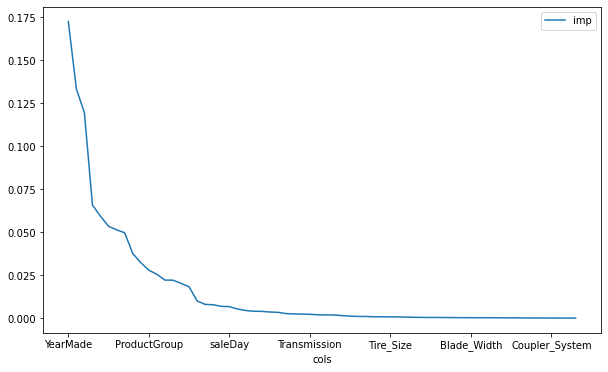

In [44]:
fi.plot('cols', 'imp', figsize=(10, 6))

In [45]:
def plot_feature_imp(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

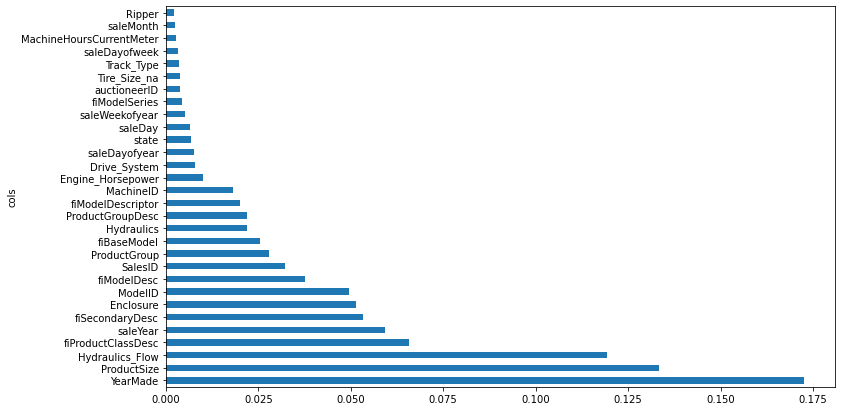

In [46]:
plot_feature_imp(fi[:30])

In [47]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

22

In [48]:
df_keep= df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, trn_size)

In [49]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['keep: ', m.oob_score_])

['Train_RMSE:', 0.1260263896577933, 'Test_RMSE:', 0.2417351841043578, 'R²_Train:', 0.9669750006947601, 'R²_Test:', 0.8928789009934385, ['OOB: ', 0.9088517567607705]]


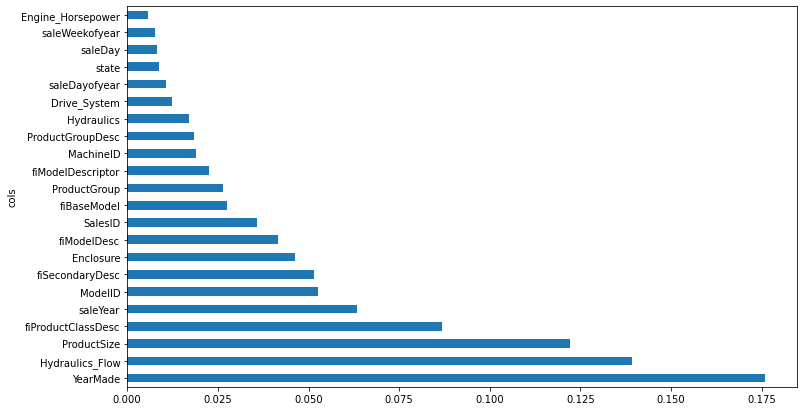

In [50]:
fi = rf_feat_importance(m, df_keep)
plot_feature_imp(fi)

Our model got slightly worse/marginaly better with less features. Let's have a closer look at the most important variables.

# 3.3 EDA/Feature Engineering on the most important variables

### YearMade

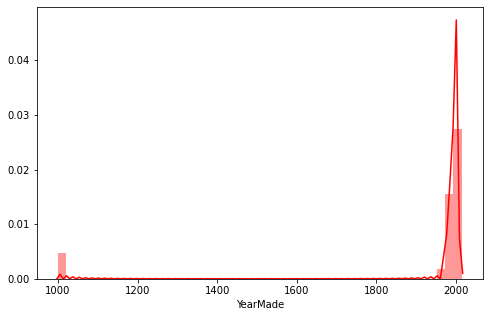

In [51]:
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df_tmp['YearMade'], ax=ax, color='r')

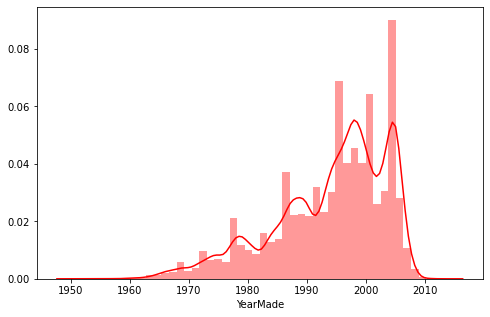

In [52]:
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(df_tmp[df_tmp['YearMade'] >= 1950]['YearMade'], ax=ax, color='r')

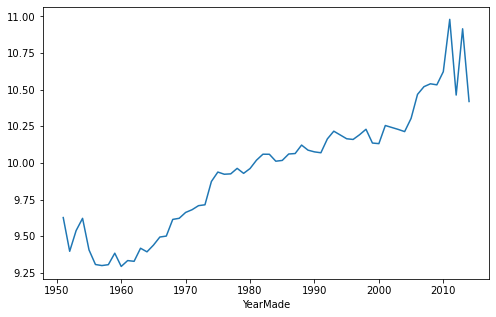

In [53]:
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
df_tmp[df_tmp['YearMade'] > 1950].groupby('YearMade')['SalePrice'].mean().plot()

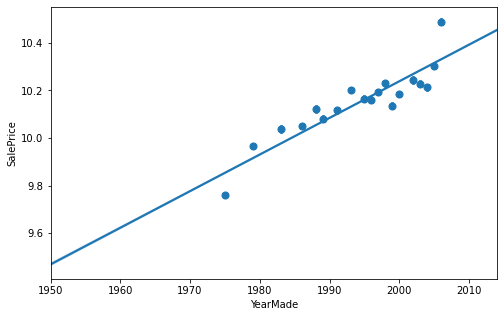

In [54]:
fig_dims = (8, 5)
fig, ax = plt.subplots(figsize=fig_dims)
sns.regplot('YearMade', 'SalePrice', data=df_tmp[df_tmp['YearMade'] >= 1950], x_bins=20)   

In [55]:
x_all = get_sample(df_tmp[df_tmp.YearMade>1930], 500)

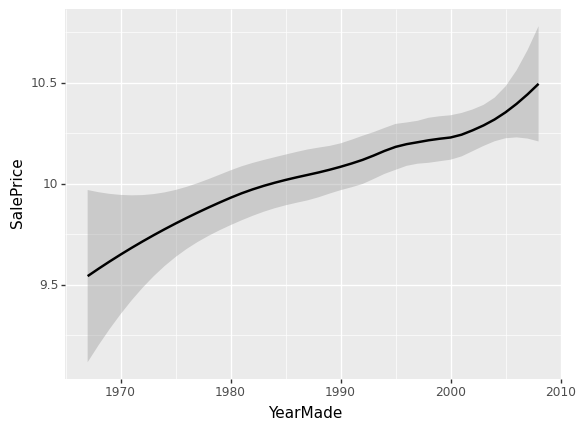

<ggplot: (8763326043042)>

In [56]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [57]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

def plot_pdp(feat, clusters = None, feat_name = None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feature = feat, model_features = x.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines = True,
                        cluster = clusters is not None,
                        n_cluster_centers = clusters)


(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f85eef63cf8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f85ed6c0978>})

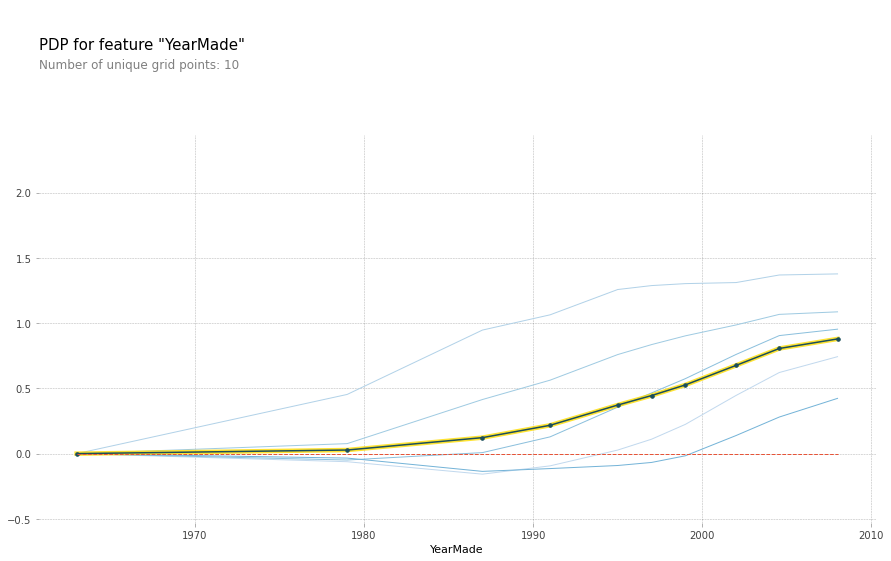

In [58]:
plot_pdp('YearMade', clusters=5)

In [59]:
####

In [60]:
df_keep.loc[df_keep.YearMade<1950, 'YearMade'] = np.nan
fix_na_num(df_keep, 'YearMade')

In [61]:
df_keep['age'] = df_keep.saleYear - df_keep.YearMade


In [62]:
df_keep.age.unique()

array([  2.,   8.,   3.,  10.,   4.,  11.,   1.,   7.,   5.,  14.,   6.,  15.,   9.,  13.,  21.,  17.,  25.,
        12.,  18.,  36.,  28.,  24.,  20.,  27.,  19.,  30.,  16.,  35.,  31.,   0.,  38.,  23.,  29.,  22.,
        26.,  32.,  33.,  41.,  34.,  39.,  37.,  40.,  43.,  45.,  -2.,  -1.,  48.,  -5.,  55.,  56.,  50.,
        57.,  59.,  58.,  42.,  47.,  46.,  44.,  49.,  -7.,  51., -12.,  52., -10., -11.,  54.,  53.,  60.])

Negative age is not possible so we fix this by setting year made to the value of saleyear

In [63]:
tmp= df_keep.query("saleYear < YearMade")[['YearMade','saleYear']]
tmp

,YearMade,saleYear
24007,1996.0,1994
24009,1996.0,1995
24015,1996.0,1994
24029,1996.0,1995
24064,1996.0,1995
...,...,...
295706,2012.0,2010
297931,2009.0,2008
395524,2013.0,2011
409039,2014.0,2012


In [64]:
df_keep.loc[df_keep.eval("saleYear < YearMade"), 'YearMade'] = df_keep['saleYear']
# adjust age column
df_keep['age'] = df_keep.saleYear - df_keep.YearMade

In [65]:
X_train, X_valid = split_vals(df_keep, trn_size)

In [66]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['YearMade/age: ', m.oob_score_])

['Train_RMSE:', 0.1251886194366382, 'Test_RMSE:', 0.24728566094085805, 'R²_Train:', 0.967412613810238, 'R²_Test:', 0.8879032151202266, ['OOB: ', 0.908984398991586]]


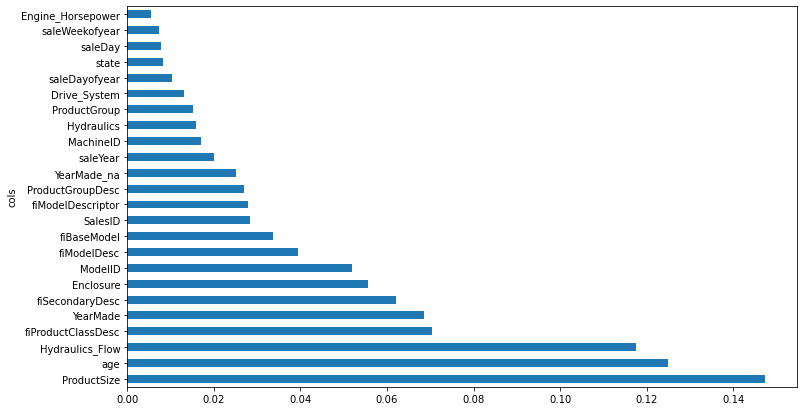

In [67]:
fi = rf_feat_importance(m, df_keep)
plot_feature_imp(fi)

### Hydraulics Flow

In [68]:
print(df_raw.Hydraulics_Flow.value_counts(dropna=False))

NaN                    367823
Standard                44251
High Flow                 597
None or Unspecified        27
Name: Hydraulics_Flow, dtype: int64


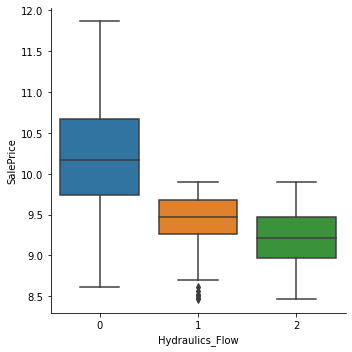

In [69]:
sns.catplot(x='Hydraulics_Flow', y='SalePrice', data=df_tmp, kind="box")

- if standard or high flow log price stays under 10k
- class imbalance, around 90% are NaN
- should be one-hot encoded

In [70]:
#df_keep['Hydraulics_Flow'] = df_tmp['Hydraulics_Flow']

In [71]:
#df_keep =df_keep.drop(df_keep.iloc[:, -6:], axis = 1) 

In [72]:
oh = pd.get_dummies(df_keep['Hydraulics_Flow'], prefix='Hydraulics_Flow',dtype=bool)
df_keep = pd.concat([df_keep, oh], axis=1)
del df_keep['Hydraulics_Flow']

In [75]:
display_all(df_keep.head())

,YearMade,ProductSize,fiProductClassDesc,saleYear,fiSecondaryDesc,Enclosure,ModelID,fiModelDesc,SalesID,ProductGroup,fiBaseModel,Hydraulics,ProductGroupDesc,fiModelDescriptor,MachineID,Engine_Horsepower,Drive_System,saleDayofyear,state,saleDay,saleWeekofyear,YearMade_na,age,Hydraulics_Flow_0,Hydraulics_Flow_1,Hydraulics_Flow_2
0,2004.0,0,59,2006,43,3,3157,963,1139246,6,298,1,6,0,999089,0,0,320,1,16,46,False,2.0,True,False,False
1,1996.0,4,62,2004,57,3,77,1745,1139248,6,529,1,6,0,117657,0,0,86,33,26,13,False,8.0,True,False,False
2,2001.0,0,39,2004,0,5,7009,336,1139249,3,111,4,3,0,434808,0,0,57,32,26,9,False,3.0,False,False,True
3,2001.0,6,8,2011,0,3,332,3716,1139251,4,1381,1,4,0,1026470,0,0,139,44,19,20,False,10.0,True,False,False
4,2007.0,0,40,2009,0,1,17311,4261,1139253,3,1538,4,3,0,1057373,0,0,204,32,23,30,False,2.0,False,False,True


In [76]:
X_train, X_valid = split_vals(df_keep, trn_size)

In [77]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['hydraulics_flow_oh: ', m.oob_score_])    

['Train_RMSE:', 0.12542260212379158, 'Test_RMSE:', 0.24895278354197492, 'R²_Train:', 0.9672906856376347, 'R²_Test:', 0.8863866773392256, ['OOB: ', 0.9090436255139654]]


### ProductSize

In [78]:
df_raw.ProductSize.values

array([None, 'Medium', None, ..., 'Mini', 'Mini', 'Mini'], dtype=object)

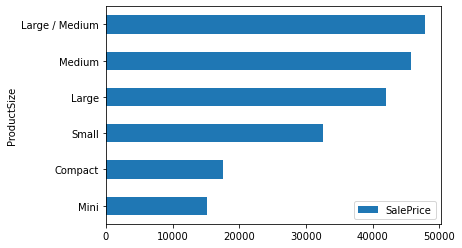

In [79]:
temp = df_raw
temp = temp.groupby('ProductSize').mean()
temp[['SalePrice']].sort_values('SalePrice').plot.barh()

In [80]:
sizes = {None:0, 'Mini':1, 'Compact':1, 'Small':2, 'Medium':3,
         'Large / Medium':4, 'Large':5}
df_keep['ProductSize'] = df_raw['ProductSize'].map(sizes).values
print(df_keep['ProductSize'].unique())

[0 4 3 5 1 6 2]


In [81]:
display_all(df_keep)

,YearMade,ProductSize,fiProductClassDesc,saleYear,fiSecondaryDesc,Enclosure,ModelID,fiModelDesc,SalesID,ProductGroup,fiBaseModel,Hydraulics,ProductGroupDesc,fiModelDescriptor,MachineID,Engine_Horsepower,Drive_System,saleDayofyear,state,saleDay,saleWeekofyear,YearMade_na,age,Hydraulics_Flow_0,Hydraulics_Flow_1,Hydraulics_Flow_2
0,2004.0,0,59,2006,43,3,3157,963,1139246,6,298,1,6,0,999089,0,0,320,1,16,46,False,2.0,True,False,False
1,1996.0,4,62,2004,57,3,77,1745,1139248,6,529,1,6,0,117657,0,0,86,33,26,13,False,8.0,True,False,False
2,2001.0,0,39,2004,0,5,7009,336,1139249,3,111,4,3,0,434808,0,0,57,32,26,9,False,3.0,False,False,True
3,2001.0,3,8,2011,0,3,332,3716,1139251,4,1381,1,4,0,1026470,0,0,139,44,19,20,False,10.0,True,False,False
4,2007.0,0,40,2009,0,1,17311,4261,1139253,3,1538,4,3,0,1057373,0,0,204,32,23,30,False,2.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,2005.0,1,13,2012,108,1,21435,490,6333344,4,160,11,4,0,1919201,0,0,67,44,7,10,False,7.0,True,False,False
412694,2005.0,1,17,2012,108,1,21436,491,6333345,4,160,4,4,0,1882122,0,0,28,9,28,4,False,7.0,True,False,False
412695,2005.0,1,13,2012,108,1,21435,490,6333347,4,160,4,4,0,1944213,0,0,28,9,28,4,False,7.0,True,False,False
412696,2006.0,1,13,2012,108,1,21435,490,6333348,4,160,4,4,0,1794518,0,0,67,44,7,10,False,6.0,True,False,False


In [82]:
df_keep.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   YearMade            412698 non-null  float64
 1   ProductSize         412698 non-null  int64  
 2   fiProductClassDesc  412698 non-null  int8   
 3   saleYear            412698 non-null  int64  
 4   fiSecondaryDesc     412698 non-null  int16  
 5   Enclosure           412698 non-null  int8   
 6   ModelID             412698 non-null  int64  
 7   fiModelDesc         412698 non-null  int16  
 8   SalesID             412698 non-null  int64  
 9   ProductGroup        412698 non-null  int8   
 10  fiBaseModel         412698 non-null  int16  
 11  Hydraulics          412698 non-null  int8   
 12  ProductGroupDesc    412698 non-null  int8   
 13  fiModelDescriptor   412698 non-null  int16  
 14  MachineID           412698 non-null  int64  
 15  Engine_Horsepower   412698 non-nul

In [83]:
X_train, X_valid = split_vals(df_keep, trn_size)

In [84]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['ProductSize: ', m.oob_score_]) 

['Train_RMSE:', 0.12526055816303497, 'Test_RMSE:', 0.24883008002789253, 'R²_Train:', 0.9673751508421876, 'R²_Test:', 0.8864986449034257, ['OOB: ', 0.909250561420541]]


In [85]:
results

[['Baseline: ', 0.9099025433645491],
 ['keep: ', 0.9088517567607705],
 ['YearMade/age: ', 0.908984398991586],
 ['hydraulics_flow_oh: ', 0.9090436255139654],
 ['ProductSize: ', 0.909250561420541]]

### fiProductClassDesc

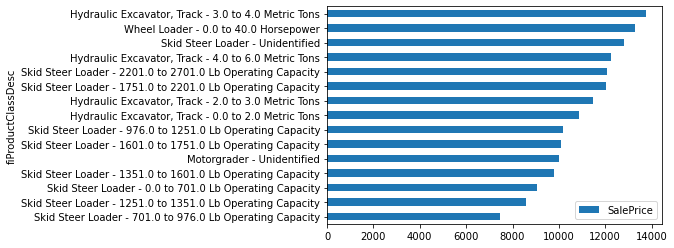

In [86]:
temp = df_raw.groupby('fiProductClassDesc').mean()
temp[['SalePrice']].sort_values('SalePrice').head(15).plot.barh()

In [87]:
df_split = df_raw.fiProductClassDesc.str.split(' - ', expand=True).values

In [88]:
df_keep['fiProductClassDesc'] = df_split[:,0]
df_keep['fiProductClassSpec'] = df_split[:,1]
print(df_keep['fiProductClassDesc'].unique())

['Wheel Loader' 'Skid Steer Loader' 'Hydraulic Excavator, Track' 'Backhoe Loader' 'Track Type Tractor, Dozer'
 'Motorgrader']


In [89]:
pattern = r'([0-9.\+]*)(?: to ([0-9.\+]*)|\+) ([a-zA-Z ]*)'
df_split = df_keep['fiProductClassSpec'].str.extract(pattern, expand=True).values
df_keep['fiProductClassSpec_lower'] = pd.to_numeric(df_split[:,0])
df_keep['fiProductClassSpec_upper'] = pd.to_numeric(df_split[:,1])
df_keep['fiProductClassSpec_units'] = df_split[:,2]
del df_keep['fiProductClassSpec'] # remove temporary column
df_keep.filter(regex=('fiProductClassSpec*')).head(3)

,fiProductClassSpec_lower,fiProductClassSpec_upper,fiProductClassSpec_units
0,110.0,120.0,Horsepower
1,150.0,175.0,Horsepower
2,1351.0,1601.0,Lb Operating Capacity


In [90]:
fix_na_num(df_keep, 'fiProductClassSpec_lower')
fix_na_num(df_keep, 'fiProductClassSpec_upper')
# label encode fiProductClassDesc fiProductClassSpec_units
to_cat(df_keep)
to_catcode(df_keep)

In [91]:
X_train, X_valid = split_vals(df_keep, trn_size)

In [92]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['fiProductClassDesc: ', m.oob_score_]) 

['Train_RMSE:', 0.12563584472123865, 'Test_RMSE:', 0.24892367433606236, 'R²_Train:', 0.967179366808722, 'R²_Test:', 0.8864132446280683, ['OOB: ', 0.9093094610941479]]


In [93]:
results

[['Baseline: ', 0.9099025433645491],
 ['keep: ', 0.9088517567607705],
 ['YearMade/age: ', 0.908984398991586],
 ['hydraulics_flow_oh: ', 0.9090436255139654],
 ['ProductSize: ', 0.909250561420541],
 ['fiProductClassDesc: ', 0.9093094610941479]]

### Enclosure

In [94]:
print(df_raw.Enclosure.value_counts(dropna=False))

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
NaN                       334
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64


In [95]:
df_keep['Enclosure'] = df_raw['Enclosure'].values
df_keep['Enclosure'] = df_keep['Enclosure'].replace('EROPS w AC', 'EROPS AC')
df_keep['Enclosure'] = df_keep['Enclosure'].replace('None or Unspecified', np.nan)
df_keep['Enclosure'] = df_keep['Enclosure'].replace('NO ROPS', np.nan)

In [96]:
df_tmp['Enclosure'] = df_raw['Enclosure'].values
df_tmp['Enclosure'] = df_tmp['Enclosure'].replace('EROPS w AC', 'EROPS AC')
df_tmp['Enclosure'] = df_tmp['Enclosure'].replace('None or Unspecified', np.nan)
df_tmp['Enclosure'] = df_tmp['Enclosure'].replace('NO ROPS', np.nan)

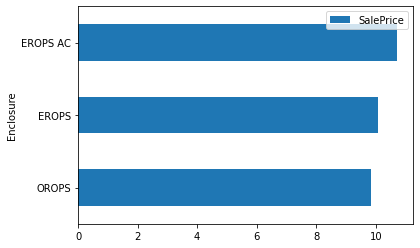

In [97]:
temp = df_tmp.groupby('Enclosure').mean()
temp[['SalePrice']].sort_values('SalePrice').plot.barh()

In [98]:
onehot = pd.get_dummies(df_keep['Enclosure'], prefix='Enclosure', dtype=bool)
del df_keep['Enclosure']
df_keep = pd.concat([df_keep, onehot], axis=1)

In [99]:
df_keep.head()

,YearMade,ProductSize,fiProductClassDesc,saleYear,fiSecondaryDesc,ModelID,fiModelDesc,SalesID,ProductGroup,fiBaseModel,...,Hydraulics_Flow_1,Hydraulics_Flow_2,fiProductClassSpec_lower,fiProductClassSpec_upper,fiProductClassSpec_units,fiProductClassSpec_lower_na,fiProductClassSpec_upper_na,Enclosure_EROPS,Enclosure_EROPS AC,Enclosure_OROPS
0,2004.0,0,6,2006,43,3157,963,1139246,6,298,...,False,False,110.0,120.0,2,False,False,False,True,False
1,1996.0,4,6,2004,57,77,1745,1139248,6,529,...,False,False,150.0,175.0,2,False,False,False,True,False
2,2001.0,0,4,2004,0,7009,336,1139249,3,111,...,False,True,1351.0,1601.0,3,False,False,False,False,True
3,2001.0,3,2,2011,0,332,3716,1139251,4,1381,...,False,False,12.0,14.0,4,False,False,False,True,False
4,2007.0,0,4,2009,0,17311,4261,1139253,3,1538,...,False,True,1601.0,1751.0,3,False,False,True,False,False


In [100]:
X_train, X_valid = split_vals(df_keep, trn_size)

In [101]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['Enclosure: ', m.oob_score_]) 

['Train_RMSE:', 0.12621506822616738, 'Test_RMSE:', 0.2503348655650509, 'R²_Train:', 0.9668760408814424, 'R²_Test:', 0.8851217082032937, ['OOB: ', 0.9083028030401114]]


In [102]:
results

[['Baseline: ', 0.9099025433645491],
 ['keep: ', 0.9088517567607705],
 ['YearMade/age: ', 0.908984398991586],
 ['hydraulics_flow_oh: ', 0.9090436255139654],
 ['ProductSize: ', 0.909250561420541],
 ['fiProductClassDesc: ', 0.9093094610941479],
 ['Enclosure: ', 0.9083028030401114]]

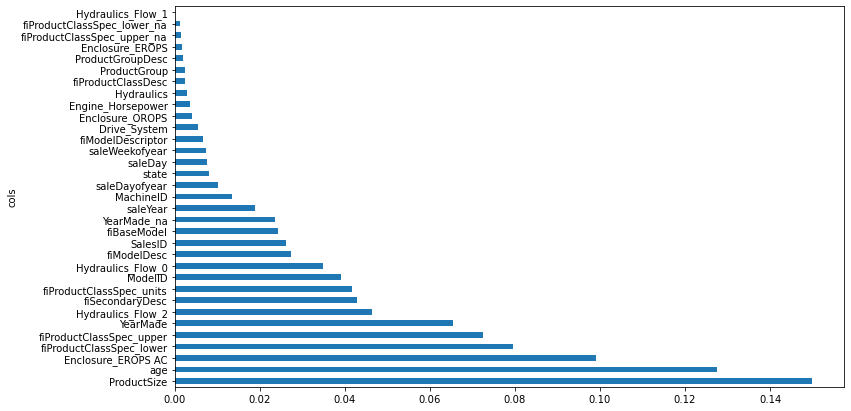

In [103]:
fi = rf_feat_importance(m, df_keep)
plot_feature_imp(fi)

### fiSecondaryDesc

In [104]:
print(df_raw.fiSecondaryDesc.value_counts(dropna=False))

NaN    140727
C       44431
B       40165
G       37915
H       24729
        ...  
CKB         1
CLR         1
BH          1
IV          1
NLC         1
Name: fiSecondaryDesc, Length: 178, dtype: int64


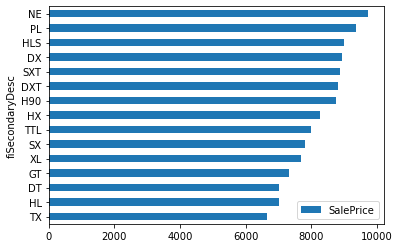

In [105]:
temp = df_raw.groupby('fiSecondaryDesc').mean()
temp[['SalePrice']].sort_values('SalePrice').head(15).plot.barh()

Since this variable has so many levels, we do not one hot encode it. 

### fiModelDesc



In [106]:
print(df_raw.fiModelDesc.value_counts(dropna=False))

310G        5348
416C        4976
580K        4364
310E        4296
140G        4186
            ... 
PC360          1
215S3          1
BL370B         1
ZX330CLC       1
PC75UR         1
Name: fiModelDesc, Length: 5059, dtype: int64


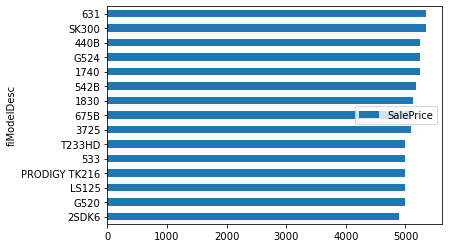

In [107]:
temp = df_raw.groupby('fiModelDesc').mean()
temp[['SalePrice']].sort_values('SalePrice').head(15).plot.barh()

Since this variable has so many levels, we do not one hot encode it. 

### SalesID

Since SalesID is a unique identifier for a specific auction, it has no predictive value. We can drop Sales ID.

In [108]:
del df_keep['SalesID']

In [109]:
X_train, X_valid = split_vals(df_keep, trn_size)

In [110]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['SalesID: ', m.oob_score_]) 

['Train_RMSE:', 0.12923633294789566, 'Test_RMSE:', 0.25063550989162775, 'R²_Train:', 0.965271255734955, 'R²_Test:', 0.8848456120564069, ['OOB: ', 0.9081431869325278]]


In [111]:
results

[['Baseline: ', 0.9099025433645491],
 ['keep: ', 0.9088517567607705],
 ['YearMade/age: ', 0.908984398991586],
 ['hydraulics_flow_oh: ', 0.9090436255139654],
 ['ProductSize: ', 0.909250561420541],
 ['fiProductClassDesc: ', 0.9093094610941479],
 ['Enclosure: ', 0.9083028030401114],
 ['SalesID: ', 0.9081431869325278]]

### Removing redundant features

We will no check if any of our remaining features are redundant.

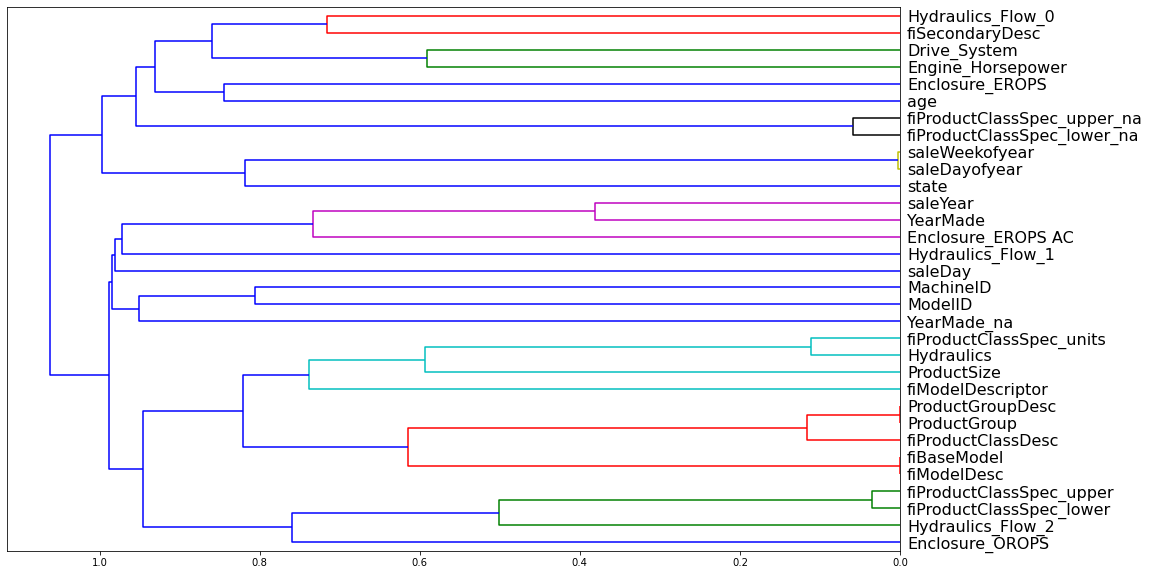

In [112]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

We will remove some of the related features and measure if model accuracy is impacted.

In [113]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, trn_size)
    m.fit(x, y_train)
    return m.oob_score_

In [114]:
get_oob(df_keep)

0.9064178793110766

In [115]:
for c in ('saleWeekofyear', 'saleDayofyear', 'ProductGroup', 'ProductGroupDesc', 'fiBaseModel', 'fiModelDesc'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleWeekofyear 0.9057914408163118
saleDayofyear 0.9059585379518025
ProductGroup 0.9059896623626208
ProductGroupDesc 0.9061000607343311
fiBaseModel 0.9050759032731431
fiModelDesc 0.905010559112188


In [118]:
to_drop = ['saleWeekofyear', 'ProductGroup']
get_oob(df_keep.drop(to_drop, axis=1))

0.9062530667459777

In [125]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
results.append(['RedundantFeat: ', m.oob_score_]) 

['Train_RMSE:', 0.12933646591621475, 'Test_RMSE:', 0.2507854563890472, 'R²_Train:', 0.9652174188709827, 'R²_Test:', 0.8847077851198836, ['OOB: ', 0.9079890006721351]]


In [126]:
results

[['Baseline: ', 0.9099025433645491],
 ['keep: ', 0.9088517567607705],
 ['YearMade/age: ', 0.908984398991586],
 ['hydraulics_flow_oh: ', 0.9090436255139654],
 ['ProductSize: ', 0.909250561420541],
 ['fiProductClassDesc: ', 0.9093094610941479],
 ['Enclosure: ', 0.9083028030401114],
 ['SalesID: ', 0.9081431869325278],
 ['RedundantFeat: ', 0.9079890006721351]]

## Extrapolation

In [143]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:trn_size] = 0

In [176]:
??proc_df

In [144]:
x , y= df_ext.drop(['is_valid'], axis=1), df_ext['is_valid']

In [145]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9996849996849997

In [146]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
3,saleYear,0.852870
11,MachineID,0.071288
14,saleDayofyear,0.043586
18,age,0.007590
5,ModelID,0.005810
0,YearMade,0.004528
6,fiModelDesc,0.002543
16,saleDay,0.001953
7,fiBaseModel,0.001684
23,fiProductClassSpec_upper,0.001346


In [147]:
feats = ['saleYear', 'MachineID', 'saleDayofyear']

In [148]:
(X_train[feats]/1000).describe()

,saleYear,MachineID,saleDayofyear
count,400698.000000,400698.000000,400698.000000
mean,2.004088,1217.289163,0.179870
std,0.005753,440.761263,0.103549
min,1.989000,0.000000,0.002000
25%,2.000000,1088.491250,0.084000
50%,2.006000,1279.127000,0.168000
75%,2.009000,1467.527000,0.271000
max,2.011000,2486.330000,0.365000


In [149]:
(X_valid[feats]/1000).describe()

,saleYear,MachineID,saleDayofyear
count,12000.000000,12000.000000,12000.000000
mean,2.011964,1656.546814,0.073744
std,0.000185,642.566886,0.048687
min,2.011000,0.150000,0.001000
25%,2.012000,1142.787750,0.044000
50%,2.012000,1861.335500,0.068000
75%,2.012000,2268.800000,0.089000
max,2.012000,2485.252000,0.364000


In [150]:
x.drop(feats, axis=1, inplace=True)

In [151]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.3, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9931063392601854

In [152]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,YearMade,0.350241
15,age,0.346612
13,saleDay,0.066159
12,state,0.050132
4,ModelID,0.032579
14,YearMade_na,0.028002
5,fiModelDesc,0.024186
6,fiBaseModel,0.020413
19,fiProductClassSpec_lower,0.014171
20,fiProductClassSpec_upper,0.013516


In [153]:
feats = ['saleYear', 'MachineID', 'saleDayofyear', 'YearMade', 'age', 'saleDay']

In [155]:
X_train, X_valid = split_vals(df_keep, trn_size)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

['Train_RMSE:', 0.13032542680661435, 'Test_RMSE:', 0.2511609827208795, 'R²_Train:', 0.9646834607908463, 'R²_Test:', 0.8843622493113401, ['OOB: ', 0.908289382633092]]


In [158]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, trn_size)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

saleYear
['Train_RMSE:', 0.1348263772840733, 'Test_RMSE:', 0.25529967446200835, 'R²_Train:', 0.9622019358290405, 'R²_Test:', 0.8805198359595933, ['OOB: ', 0.9036776200935974]]
MachineID
['Train_RMSE:', 0.13609187184535437, 'Test_RMSE:', 0.25121790329542937, 'R²_Train:', 0.9614890526449553, 'R²_Test:', 0.8843098294410616, ['OOB: ', 0.9096218383373215]]
saleDayofyear
['Train_RMSE:', 0.13840841220649797, 'Test_RMSE:', 0.25191950017499093, 'R²_Train:', 0.9601668363755116, 'R²_Test:', 0.8836627322105425, ['OOB: ', 0.905077866793266]]
YearMade
['Train_RMSE:', 0.13280452259037012, 'Test_RMSE:', 0.2614831329548174, 'R²_Train:', 0.9633270744235615, 'R²_Test:', 0.8746620325169295, ['OOB: ', 0.9069430134645907]]
age
['Train_RMSE:', 0.1322351589644761, 'Test_RMSE:', 0.24157093444028221, 'R²_Train:', 0.9636408509469916, 'R²_Test:', 0.8930244207874839, ['OOB: ', 0.9083163905159154]]
saleDay
['Train_RMSE:', 0.13495517974267612, 'Test_RMSE:', 0.2508361168966583, 'R²_Train:', 0.962129682770316, 'R²_Tes

In [177]:
df_subs = df_keep.drop(['MachineID', 'age', 'saleDay'], axis=1)
X_train, X_valid = split_vals(df_subs, trn_size)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

['Train_RMSE:', 0.1433127077725396, 'Test_RMSE:', 0.23999740234946632, 'R²_Train:', 0.9572939670697196, 'R²_Test:', 0.8944135057720163, ['OOB: ', 0.9105390193222292]]


In [237]:
def preprocess_df(df):
    

    def string_norm(df):
        for col in df.columns:
            if is_string_dtype(df[col]) or is_object_dtype(df[col]):
                df[col] = df[col].str.lower()
                df[col] = df[col].fillna(np.nan) 
                df[col] = df[col].replace('none or unspecified', np.nan)
                df[col] = df[col].replace('none', np.nan)
                df[col] = df[col].replace('', np.nan)
            
    string_norm(df)
    
    def fix_na_num (df, col):
        df[col+'_na'] = pd.isnull(df[col]) 
        df[col].fillna(df[col].median(), inplace=True)
        
    df.loc[df.YearMade<1950, 'YearMade'] = np.nan
    fix_na_num(df, 'YearMade')
    
    def prep_date(df, date_col):
        df["saleYear"] = df[date_col].dt.year
        df["saleMonth"] = df[date_col].dt.month
        df["saleDay"] = df[date_col].dt.day
        df["saleDayofweek"] = df[date_col].dt.dayofweek
        df["saleWeekofyear"] = df[date_col].dt.weekofyear
        df["saleDayofyear"] = df[date_col].dt.dayofyear
        df["saleQuarter"] = df[date_col].dt.quarter
        df["saleIsWeekend"] = np.where((df[date_col].dt.day_name == ['Sunday', 'Saturday']),1,0)
        df["saleIsQuarterStart"] = np.where(df[date_col].dt.month.isin([1, 4, 7, 10]),1 ,0)
        df["saleIsQuarterEnd"] = np.where(df[date_col].dt.month.isin([3, 6, 9, 12]),1 ,0)
        df.loc[df.eval("saleYear < YearMade"), 'YearMade'] = df['saleYear']
        df['age'] = df.saleYear - df.YearMade
        df.drop(date_col, axis=1, inplace=True)
    
        return df

    
    df= prep_date(df, 'saledate')
    
    
    df['auctioneerID'] = df['auctioneerID'].astype(str)
     
    
    fix_na_num(df, 'MachineHoursCurrentMeter')
    

    print('lol')
    def remove_inch(df, colname):
        df[colname] = df[colname].str.extract(r'([0-9.]*)', expand=True)
        df[colname] = pd.to_numeric(df[colname])

    remove_inch(df, 'Tire_Size')
    remove_inch(df, 'Undercarriage_Pad_Width')
    fix_na_num(df, 'Tire_Size')
    fix_na_num(df, 'Undercarriage_Pad_Width')
    
    def to_cat(df):
        for col in df.columns:
            if is_string_dtype(df[col]):
                df[col] = df[col].astype('category').cat.as_ordered()

    def to_catcode(df):
        for col in df.columns:
            if is_categorical_dtype(df[col]):
                df[col] = df[col].cat.codes + 1
                
    to_cat(df)
    #to_catcode(df)
    
    # One Hot Encode
    
    def onehot(df, colname):
    ascat = df[colname].astype('category').cat.as_ordered()
    onehot = pd.get_dummies(df[colname], prefix=colname, dtype=bool)
    del df[colname]
    df = pd.concat([df, onehot], axis=1)
    # return altered dataframe and column training categories
    return df, ascat.cat.categories

    oh = pd.get_dummies(df['Hydraulics_Flow'], prefix='Hydraulics_Flow',dtype=bool)
    df = pd.concat([df, oh], axis=1)
    del df['Hydraulics_Flow']
    
    df['SalePrice'] = np.log(df['SalePrice'])
    
    return df

In [ ]:
def feat_eng (df):
    
    df= df[to_keep].copy()
    
    df.loc[df.YearMade<1950, 'YearMade'] = np.nan
    fix_na_num(df, 'YearMade')
    df['age'] = df.saleYear - df.YearMade

In [ ]:
#def one_hot(df, fld):
 #   oh = pd.get_dummies(df[fld], prefix=fld, dtype=bool)
  #  df = pd.concat([df, oh], axis=1)

#one_hot(df = df_keep,fld='Hydraulics_Flow')
#one_hot(df_tmp, 'Hydraulics_Flow')